## Matching catalogues to the VAST Pilot Survey

This notebook gives an example of how to use vast-tools in a notebook environment to perform a crossmatch between a catalogue and the VAST Pilot Survey.

Below are the imports required for this example. The main imports required from vast-tools are the Query and VASTMOCS objects. Astropy objects are also imported as they are required as input to the query.

**Note** for large queries it is recommened to use the script version of `find_sources.py` to get cutouts for **all** results.

In [1]:
from vasttools.moc import VASTMOCS
from vasttools.query import Query
from mocpy import World2ScreenMPL
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord

### Catalogue selection

For this example we will be using the `Quasars and Active Galactic Nuclei (13th Ed.) (Veron+ 2010)` catalogue, which has the Vizier ID of `VII/258`.

To start our search, the first question we want to answer is: 

*What sources from the catalogue are in the VAST Pilot Survey footprint?*

This can be efficiently answered by using the `query_vizier_vast_pilot()` method in VASTMOCS.

First we initialise the VASTMOCS object:

In [2]:
mocs = VASTMOCS()

We then use the query vizier method to obtain all the sources from the Veron catalogue which are contained within the footprint. It will likely take a bit of time to complete.

In [3]:
veron_vast_sources = mocs.query_vizier_vast_pilot('VII/258', max_rows=200000)

In [4]:
veron_vast_sources

_RAJ2000,_DEJ2000,recno,Cl,nR,Name,n_RAJ2000,RAJ2000,DEJ2000,l_z,z,Sp,n_Vmag,Vmag,B-V,r_z
deg,deg,,,,,,"""h:m:s""","""d:m:s""",,,,,mag,mag,
float64,float64,int32,bytes1,bytes1,bytes17,bytes1,bytes10,bytes9,bytes1,float32,bytes4,bytes1,float32,float32,int16
0.005417,-2.033333,1,Q,,FIRST J00000-0202,R,00 00 01.3,-02 02 00,,1.356,,,19.64,--,179
0.027500,0.515278,7,Q,*,SDSS J00001+0030,O,00 00 06.6,+00 30 55,,1.823,,,20.37,0.24,2068
0.034167,0.276389,8,Q,*,SDSS J00001+0016,O,00 00 08.2,+00 16 35,,1.837,,,20.03,0.32,2068
0.050000,0.040000,18,Q,*,PB 5669,O,00 00 12.0,+00 02 24,,0.479,,,18.06,0.13,50
0.051250,-0.538889,19,Q,*,SDSS J00002-0032,O,00 00 12.3,-00 32 20,,1.436,,,20.34,0.31,2068
0.056667,-2.172222,21,Q,,Q 2357-024,O,00 00 13.6,-02 10 20,*,1.450,,,19.40,--,2677
0.057500,-0.912778,22,Q,*,SDSS J00002-0054,O,00 00 13.8,-00 54 46,,1.836,,,20.10,0.24,2068
0.061667,-1.175000,23,Q,*,SDSS J00002-0110,O,00 00 14.8,-01 10 30,,1.890,,,19.31,0.19,2068


We see that 44,704 sources are within the VAST Pilot Survey footprint.

These can be plotted along with the VAST Pilot Survey footprint using the MOC. See the vast-mocs-example notebook for more on using MOCS and the `Wordl2ScreenMPL` method.

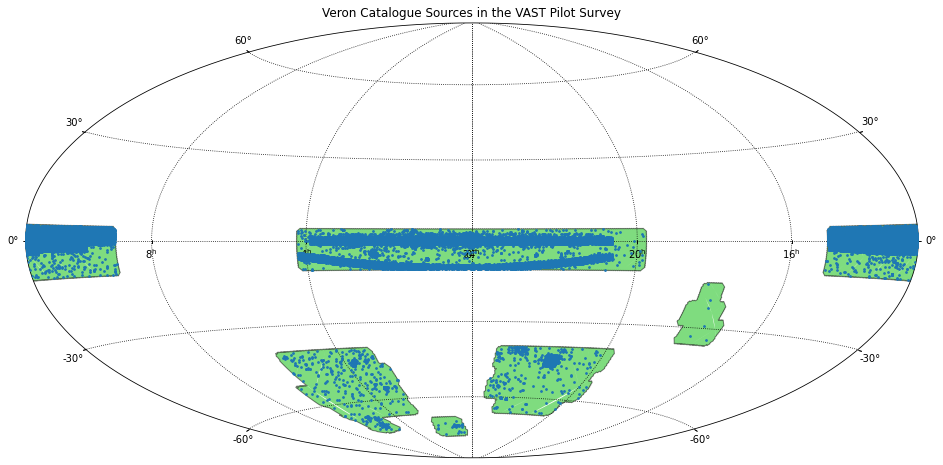

In [6]:
from astropy.visualization.wcsaxes.frame import EllipticalFrame

fig = plt.figure(figsize=(16,8))

# Load the Epoch 1 MOC file to use
epoch1_moc = mocs.load_pilot_epoch_moc('1')

# 
with World2ScreenMPL(
    fig,
    fov=320 * u.deg,
    center=SkyCoord(0, 0, unit='deg', frame='icrs'),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
) as wcs:
    ax = fig.add_subplot(111, projection=wcs, frame_class=EllipticalFrame)
    ax.set_title("Veron Catalogue Sources in the VAST Pilot Survey")
    ax.grid(color="black", linestyle="dotted")
    epoch1_moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, linewidth=0, color="#00bb00")
    epoch1_moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
    ax.scatter(
        veron_vast_sources['_RAJ2000'], 
        veron_vast_sources['_DEJ2000'], 
        transform=ax.get_transform('world'),
        zorder=10,
        s=3
    )
        
fig

### Querying the VAST Pilot Survey sources

Now we will construct a Query to see how many sources have matches to selavy componentst in the VAST Pilot Survey.

First we create the SkyCoord object and the names for the Query input:

In [6]:
# Unfortunately we cannot use guess_from_table for the Vizier results, so we construct manually
veron_skycoord = SkyCoord(veron_vast_sources['_RAJ2000'], veron_vast_sources['_DEJ2000'], unit=(u.deg, u.deg))
veron_names = veron_vast_sources['Name'].tolist()

Create the Query input where we use the option of `matches_only`. This means that only those sources that have an actual match are returned. I also explicitly do not select RACS to search here, I'm only interested in the VAST Pilot data, so I select `all-vast`. Note you must pre-create the output directory for the query if you intend to use it.

In [7]:
veron_query = Query(
    coords=veron_skycoord,
    source_names=veron_names,
    epochs='all-vast',
    max_sep=1.5,
    crossmatch_radius=10.0,
    base_folder='/import/ada1/askap/PILOT/release',
    matches_only=True,
    no_rms=True,
    output_dir='veron-vast-crossmatching', 
)

And run `find_sources` - again a warning that this will take a little while to process.

In [8]:
veron_query.find_sources()

We can check the results attribute to see how many sources return a match.

In [9]:
veron_query.results.shape[0]

4614

### Using the results

4614 sources have returned a match in the VAST Pilot Survey in any epoch.

We can create new skycoord and name objects ready for a new query:

In [10]:
matches_mask = [i in (veron_query.results) for i in veron_vast_sources['Name']]
matched_names = veron_vast_sources['Name'][matches_mask].tolist()
matched_skycoords = veron_skycoord[matches_mask]

Or loop through and save all the measurements for each source.

In [11]:
# for i in veron_query.results:
#     i.write_measurements()

While you can explore the sources as normal, for example

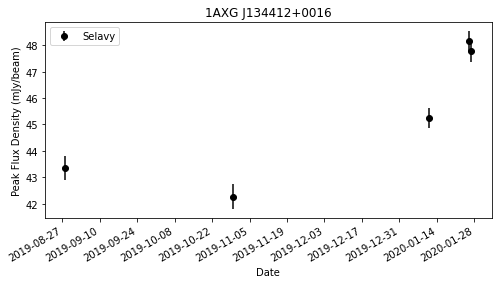

In [22]:
my_source = veron_query.results['1AXG J134412+0016']
lc = my_source.plot_lightcurve()
lc

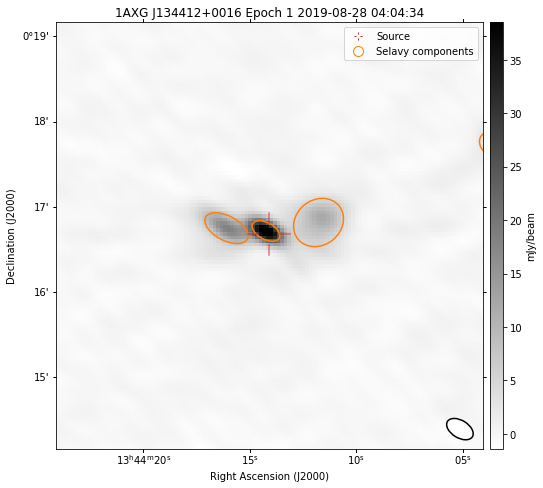

In [23]:
cutout = my_source.show_png_cutout('1')
cutout

it's not recommended to produce cut outs for all sources in the notebook as this will start to take a lot of memory and be quite slow. If you'd like to do this then please use the `find_sources.py` script.

### Further example - variability

You can also perform some rudimentary variablility analysis on the results if you wish.

I would recommened using the VAST Pipeline if possible for this kind of analysis as the associations will be much better and the you'll get a lot more information, but nevertheless this is an example of what you **can** do with the data from vast-tools.

In the code below I create a dataframe from the query results (which is a pandas series) and assign it to `variables_df` and define a function that returns the eta and V metrics for each source when passed through `.apply()`. These are then assigned to new `eta` and `v` columns in the `variables_df` dataframe.

In [14]:
import pandas as pd

def get_variable_metrics(row):
    """
    Function to return the eta and v metrics using apply.
    """
    return row['object'].calc_eta_and_v_metrics()

# create the variables_df dataframe, rename the column holding the objects as 'object'
variables_df = pd.DataFrame(veron_query.results).rename(columns={'name':'object'})
# obtain the metrics
variables_df[['eta', 'v']] = variables_df.apply(get_variable_metrics, result_type='expand', axis=1)

We can then, for example, plot the log eta distribution, making sure we choose sources that have more than 2 detections.

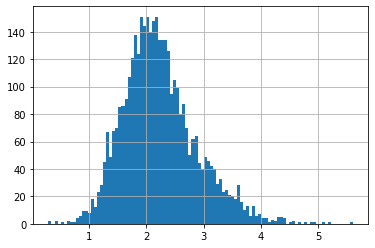

In [24]:
%matplotlib inline
mask = [i.detections > 2 for i in variables_df['object']]

import numpy as np
np.log10(variables_df.eta[mask]).hist(bins=100)
plt.show()

You could then do the same for `v` and start to fit Gaussians to the distributions and select candidates.